In [1]:
## Imports
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
import json
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.utils import shuffle
from sklearn.utils.class_weight import *
from dateutil.parser import parse
import datetime as dt
pd.options.mode.chained_assignment = None  # default='warn'
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from helpers import *

# Hybrid model with meta-data and text features

In this notebook we try to replicate once again the results of the authors of the paper "“Liar, Liar Pants on Fire”: A New Benchmark Dataset for Fake News Detection" and get some useful and interesting insights from the model trained.

Given all the meta-data regarding statements and the ouput of the text classifier on the statements we trained before, we want to predict more accurately when a specific statement is more likely to be false or true (specifically, in the range of 6 different classes of truthfulness).

In [2]:
## Define paths
DATA_FOLDER = './data/'
TRAIN_PATH = DATA_FOLDER + 'train.tsv'
TEST_PATH = DATA_FOLDER + 'test.tsv'
VALID_PATH = DATA_FOLDER + 'valid.tsv'

CLEAN_TRAIN = DATA_FOLDER + "train_clean.txt"
CLEAN_TEST = DATA_FOLDER + "test_clean.txt"
CLEAN_VALID = DATA_FOLDER + "valid_clean.txt"

In [3]:
# Data Loading

train_data = load_data(TRAIN_PATH)
test_data = load_data(TEST_PATH)
valid_data = load_data(VALID_PATH)

# Convert labels in the range 
train_data.label = convert_label(train_data)
test_data.label = convert_label(test_data)
valid_data.label = convert_label(valid_data)

In [4]:
train_data.label[train_data.label <= 0] = 0
train_data.label[train_data.label > 0] = 1

test_data.label[test_data.label <= 0] = 0
test_data.label[test_data.label > 0] = 1

valid_data.label[valid_data.label <= 0] = 0
valid_data.label[valid_data.label > 0] = 1

In [5]:
# Add sentiment analysis as a feature of the model, this can slightly improve the performance

def addSAfeatures(df):
    analyzer = SentimentIntensityAnalyzer()
    return pd.concat([df, pd.DataFrame([analyzer.polarity_scores(l) for l in df.statement])], axis=1, sort=False)

train_data = addSAfeatures(train_data)
test_data = addSAfeatures(test_data)
valid_data = addSAfeatures(valid_data)

train_data.drop(columns=["ID", "statement", "barely_true_cts", "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts"], inplace=True)
test_data.drop(columns=["ID", "statement", "barely_true_cts", "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts"], inplace=True)
valid_data.drop(columns=["ID", "statement", "barely_true_cts", "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts"], inplace=True)

In [6]:
# Adding feature that says if the statement mentions numbers or not, since we think could be an important discriminant for saying lies
has_num_tr = np.load("has_num_feat_tr.npy")
has_num_te = np.load("has_num_feat_te.npy")

train_data["has_num"] = has_num_tr
test_data["has_num"] = has_num_te

In [7]:
# Add predictions from the statement classifier based on the text of the statements
text_pred_tr = np.load("st_text_out_tr.npy")
train_data["text_feat"] = text_pred_tr

text_pred_te = np.load("st_text_out_te.npy")
test_data["text_feat"] = text_pred_te

In [8]:
# Preprocess meta-data by cleaning the features and group more categories

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)
valid_data = preprocess_data(valid_data)

In [9]:
# Converting in categorical variables

dummy_train = pd.get_dummies(train_data)
dummy_test = pd.get_dummies(test_data)
dummy_valid = pd.get_dummies(valid_data)

In [10]:
# Fitting dummy test data in order to have same size

column_set = dummy_train.columns
columns_to_fit = dummy_test.columns
to_remove = set(columns_to_fit) - set(column_set)
to_add = set(column_set) - set(columns_to_fit)

# For each class of feature we did not find, we add this our set of features with all values as 0
for addable in to_add:
    dummy_test[addable] = 0

# For each class new class of features, we attempt to add it an 'Other' feature if it exists
# If not, we simply remove it
for removable in to_remove:
    original_name = removable.split('_')[:-1]
    original_name.append('Other')
    other_col = "_".join(original_name)
    if dummy_test.columns.contains(other_col):
        dummy_test[other_col] += dummy_test[removable]
    dummy_test.drop(removable, axis=1, inplace=True)
    
# Need to sort columns for ordering compatability!
dummy_test = dummy_test.reindex_axis(column_set, axis=1)

/home/mikanikos/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.


In [11]:
# Prepare data and shuffle

X_tr = dummy_train.iloc[:,1:].values
y_tr = dummy_train.iloc[:,0].values
X_te = dummy_test.iloc[:,1:].values
y_te = dummy_test.iloc[:,0].values

X_tr, y_tr = shuffle(X_tr, y_tr)
X_te, y_te = shuffle(X_te, y_te)

In [12]:
# Standardizing data

std_scaler = StandardScaler()
X_tr = std_scaler.fit_transform(X_tr)
X_te = std_scaler.transform(X_te)

In [13]:
# Training with a Random Forest Classifier

classifier = RandomForestClassifier(n_estimators = 100)
classifier.fit(X_tr, y_tr)
probs = classifier.predict(X_te)

In [14]:
# Confusion matrix
pd.crosstab(y_te, probs, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,274,279
1,184,530


In [15]:
# Accuracy
accuracy_score(y_te, probs)

0.6345698500394633

In [16]:
# F1 score
f1_score(y_te, probs, average="micro")

0.6345698500394633

The accuracy is now higher as expected.

Once again, it is also possible to notice some other interesting things, such as the contribution of all the features.

In [17]:
importances = pd.DataFrame(classifier.feature_importances_, index = dummy_train.columns[1:], columns=['importance']).sort_values('importance', ascending=False)
importances

,importance
text_feat,9.222292e-02
neu,4.479076e-02
compound,4.368822e-02
pos,3.354218e-02
neg,3.126899e-02
has_num,1.741862e-02
context_Ad,1.143366e-02
party_democrat,8.124119e-03
context_News Program,7.518522e-03
party_republican,6.717661e-03


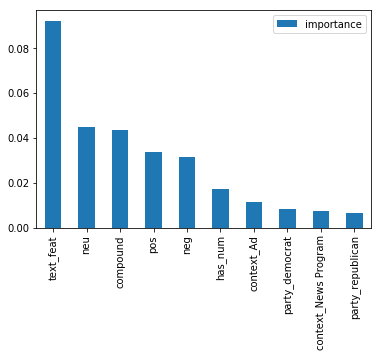

In [18]:
importances.head(10).plot.bar()

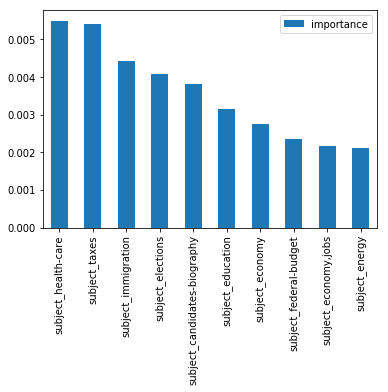

In [19]:
importances[importances.index.str.startswith('subject')].head(10).plot.bar()

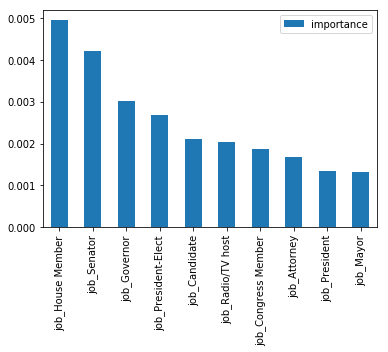

In [20]:
importances[importances.index.str.startswith('job')].head(10).plot.bar()

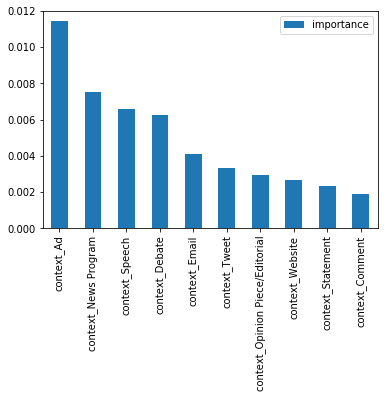

In [21]:
importances[importances.index.str.startswith('context')].head(10).plot.bar()

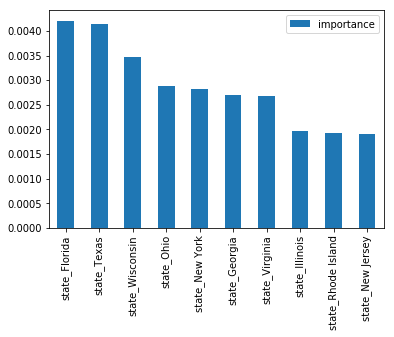

In [22]:
importances[importances.index.str.startswith('state')].head(10).plot.bar()

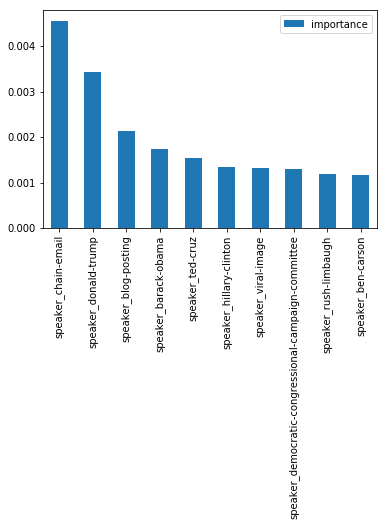

In [23]:
importances[importances.index.str.startswith('speaker')].head(10).plot.bar()

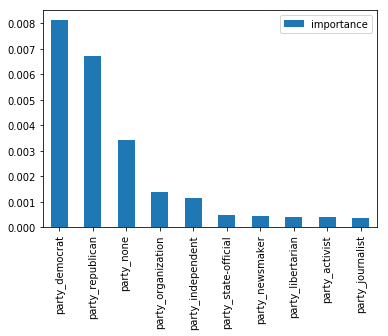

In [24]:
importances[importances.index.str.startswith('party')].head(10).plot.bar()

Here we analyze the contribution of the features for some relevant classes 

In [25]:
result = {}
for cl in set(y_tr):
    result[cl] = dict(zip(range(X_tr.shape[1]), np.mean(X_tr[y_tr==cl, :], axis=0) * classifier.feature_importances_))

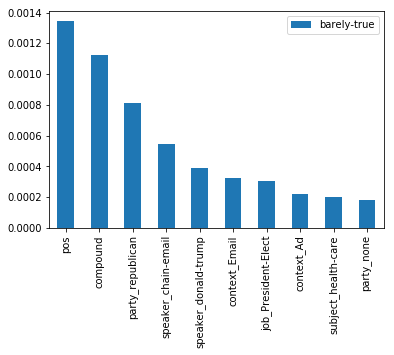

In [27]:
# false
pd.DataFrame(list(result.get(0).values()), index = dummy_train.columns[1:], columns=['barely-true']).sort_values('barely-true', ascending=False).head(10).plot.bar()

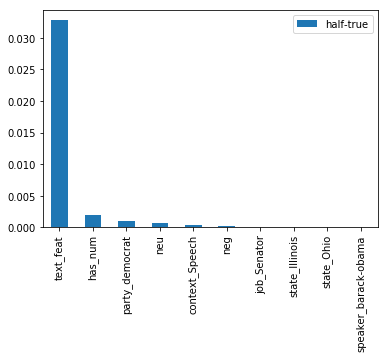

In [28]:
# true
pd.DataFrame(list(result.get(1).values()), index = dummy_train.columns[1:], columns=['half-true']).sort_values('half-true', ascending=False).head(10).plot.bar()